# Predicting a scientists rank using machine learning and generating recommendations on how to improve it

A dataset by John P.A. Ioannidis contains a ranking of ~200,000 scientists along with several metrics related to publication and citations[^1].

To generate the rank, they first calculated a score that incorporates certain metrics related to publications and citations. The scientists were then ranked according to this score.

This project aims to analyse whether a machine learning model can be used to predict this rank. Different models are going to be evaluated, from a simple linear model to more complex models which can learn non-linear relationships. After evaluating the model performance, the trained models are going to be used to give recommendations for improving an individual scientists rank.

The research questions for this project are:
- RQ1: Can machine learning be used to predict a scientists rank above baseline?
- RQ2: Can these models be used to recommend steps to improve their ranking?

To specify the list of possible recommendation, we identify the following actions:
- publish a single authored paper
- publish a first authored paper
- publish a last authored paper
- get a peer to cite their single, first, last authored paper

[^1] Ioannidis, John P.A. (2023), “October 2023 data-update for "Updated science-wide author databases of standardized citation indicators"”, Elsevier Data Repository, V6, doi: [10.17632/btchxktzyw.6](https://doi.org/10.17632/btchxktzyw.6)

In [1]:
# choose whether all model-scaler combinations should be evaluated. This can take several hours. 
# otherwise load results from file
RUN_ALL = False

# define folders and files
DATA_FOLDER = "data"
SCIENTISTS_DATASET = "Table_1_Authors_career_2022_pubs_since_1788_wopp_extracted_202310.xlsx"
DATA_SHEET = "Data"
KEY_SHEET = "Key"

RESULTS_FOLDER = "results"
RESULTS_FILE = "ml_runs_results_cv.parquet"

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# filepath to the xlsx containing the dataset
file = os.path.join(DATA_FOLDER, SCIENTISTS_DATASET)
# specify the sheets in the xlsx
sheets = [DATA_SHEET, KEY_SHEET]
# read dataset and descriptions
df, keys = pd.read_excel(file, sheet_name=sheets).values()

The xlsx contains two sheets: "Key" and "Data". 
The features used in this project are selected using the information contained in "Key".

We are going to focus on the 'rank (ns)' which excludes self-citations and therefore won't consider the features which inlude self-citations. We also won't consider the composite score 'c (ns)', as the rank is directly determined by sorting the scientists on this score.

To limit the size of the dataset, we will also exclude any categorical features, such as the institution name, the country, or the field and sub field. These features have a high cardinality which could lead to a large number of new features, depending on the encoding method. Aside from that, we don't want to recommend a scientist to change their institution or field of research.

In [4]:
# show all keys along with their descriptions
keys

,FIELD,BASIS,DESCRIPTION
0,authfull,NaN,author name
1,inst_name,NaN,institution name (large institutions only)
2,cntry,NaN,country associated with most recent institution
3,np6022,NaN,# papers 1960-2022
4,firstyr,NaN,year of first publication
5,lastyr,NaN,year of most recent publication
6,rank (ns),self-citations excluded,rank based on composite score c
7,nc9622 (ns),self-citations excluded,total cites 1996-2022
8,h22 (ns),self-citations excluded,h-index as of end-2022
9,hm22 (ns),self-citations excluded,hm-index as of end-2022


In [5]:
# define the predictor and target columns
predictors = ['np6022', 'firstyr', 'lastyr', 'nc9622 (ns)', 
              'h22 (ns)', 'hm22 (ns)', 'nps (ns)', 'ncs (ns)', 
              'cpsf (ns)', 'ncsf (ns)', 'npsfl (ns)', 'ncsfl (ns)',
              'npciting (ns)', 'cprat (ns)', 'np6022 cited9622 (ns)', 'self%']

target = 'rank (ns)'

## Visualizing the predictor and target variables

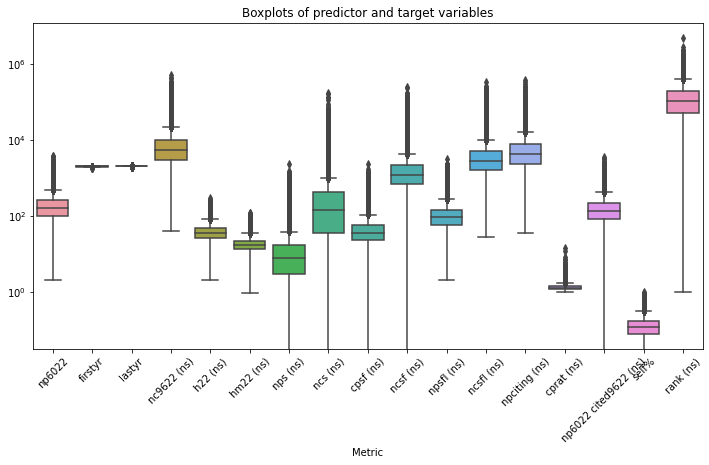

In [6]:
# boxplot of all predictors and the target
plt.figure(figsize=(12,6))
sns.boxplot(data=df[[*predictors, target]])
plt.title('Boxplots of predictor and target variables')
plt.yscale('log')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.show()

The distributions of the different predictor variables show large numbers of outliers and some outliers being deviating far from the median. One way to deal with this is to simply remove them from the dataset. In this project we will keep all outliers regarding the predictor variables and test different ways of scaling instead.

To get a better sense of the target variable's distribution, we are going to take a look at the histograms using a normal and a logarithmic scale. 

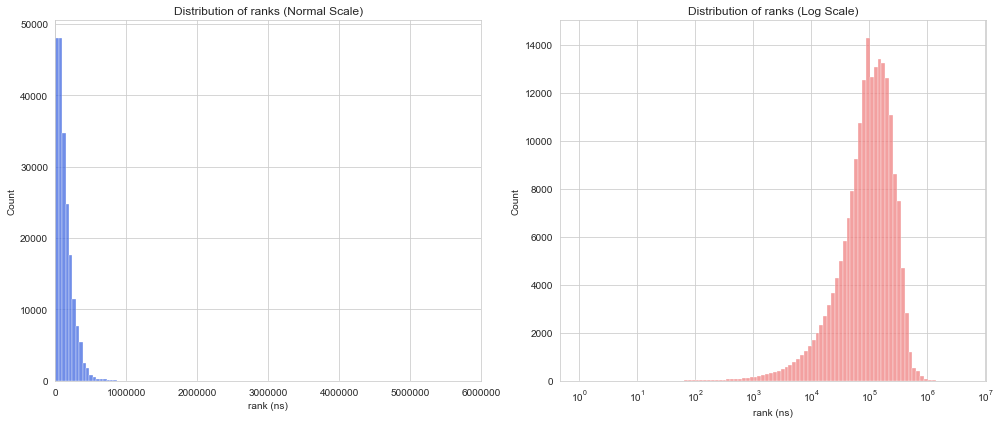

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# histogram in normal scale
plt.subplot(1, 2, 1)
sns.histplot(df[target], bins=100, log_scale=False, color='royalblue')
plt.title('Distribution of ranks (Normal Scale)')
ax = plt.gca()
ax.set_xlim(left=0)
ax.set_xticks(ax.get_xticks())
labels = ax.get_xticks().astype(int)
ax.set_xticklabels(labels)


# histogram in log scale
plt.subplot(1, 2, 2)
sns.histplot(df[target], bins=100, log_scale=True, color='lightcoral')
plt.title('Distribution of ranks (Log Scale)')

plt.tight_layout()
plt.show()

The dataset contains around 200,000 scientists. The distributions show that the ranks range well above 200,000, with some even above a million. In order to remove the largest outliers, which could distort the evaluation we decided to remove all ranks above 500,000.

In [8]:
# define rank cutoff value, all ranks above will be removed
rank_cutoff = 500_000

print(f"Remove all ranks above {rank_cutoff:,} \nThis affects {sum(df[target] > rank_cutoff):,} records.")
df = df[df['rank (ns)'] <= rank_cutoff].reset_index(drop=True)

Remove all ranks above 500,000 
This affects 2,109 records.


To get a better sense of the relationships between the features, we are going to look at their correlations.  We are using the spearman rank correlation coefficient since it doesn't have requirements regarding the distribution of the data.

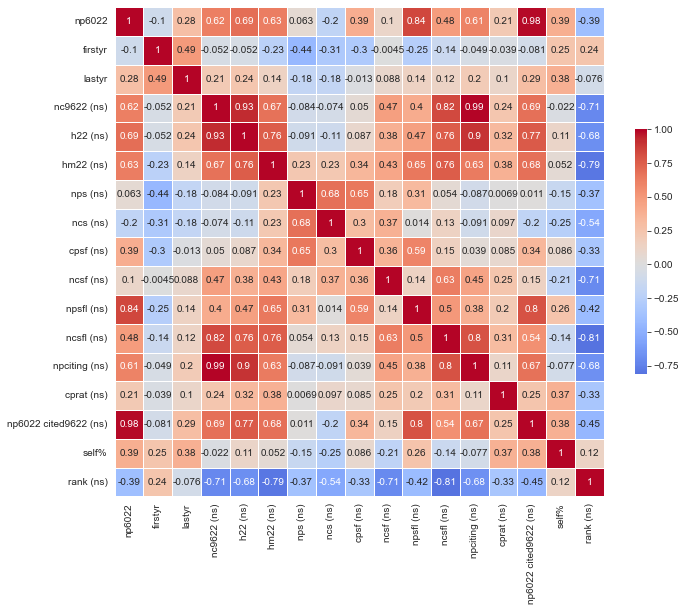

In [9]:
# get correlation matrix
corr = df[[*predictors, target]].corr(method='spearman')

# plot the correlation matrix as a heatmap
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

## Key Findings from the correlation matrix

- There are strong correlation between some of the input features.  This is not surprising, since they all rely on specific information regarding the amount of publications and their citations. 

- Except for the 'self%' and 'firstyr', all predictors have a negative correlation with the target 'rank (ns)'. This is expected since more publications and more citations generally lead to a lower (improved) rank. 

- The 'self%' features, which refers to the percentage of self citations, has a positive correlation with the rank. So citing oneself correlates to a negative impact on a scientist's ranking.

- The positive correlation between 'firstyr' and the rank indicates that scientists whose first paper was published a long time ago, tend to have better ranking.

# Machine Learning

After a first analysis of the dataset, this section is going to test different out-of-the-box machine learning models at predicting a scientists rank.

We start by defining our scalers, models and evaluation metrics. To keep this analysis simple, we are going to use the default hyperparameters. The evalution will be done using 10-fold cross-validation.

### Scalers

We decided to test standard and minmax scalers, because are often shown to lead to good results. In addition to that, we decided to add the quantile transformer, considering the outliers and distributions of the predictors.
To have a baseline of comparing the effects of the scalers against, we also define a "passthrough" scaler, which leaves the data unchanged.

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer

# additionally, we defined a passthrough scaler that leaves the dataset as it is
from sklearn.base import BaseEstimator, TransformerMixin

class PassthroughScaler(BaseEstimator, TransformerMixin):
    def __init__(self, name="PassthroughScaler"):
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X
    
scalers = [StandardScaler(), QuantileTransformer(), MinMaxScaler(), PassthroughScaler()]

### Models

We decided to use some simple linear models as well as some tree-based ensemble models, which can learn more complex patterns in the dataset.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

models = [LinearRegression(), KNeighborsRegressor(),
          DecisionTreeRegressor(), RandomForestRegressor(), ExtraTreesRegressor()]

### Metrics

We decided to use rmse and mae as evaluation metrics since they are generally useful for regression tasks.
Additionally, we included spearman rank correlation and kendall tau, since they are good at capturing the relationships between data points. This is important here, because it can be argued that predicting the order of ranks is as important as predicting the absolute rank.

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score
from scipy.stats import spearmanr, kendalltau

metrics_list = ["rmse", "mae", "spearmanr", "kendalltau", "ndcg_score"]

### Define evaluation using cross-validation

In [13]:
from sklearn.model_selection import KFold

def evaluate_model(model, scaler, metrics_list, X, y, folds=10):
    # generate folds for cross-validation
    # making sure the dataset is shuffled and a random_state is used for reproducibility
    kf = KFold(n_splits=folds, shuffle=True, random_state=0)
    
    # create a dictionary of lists for storing the metrics of each fold
    metrics = { metric_name: [] for metric_name in metrics_list }


    # iterate folds, each data point appears in the test set exactly for one fold and in the train set  for all other folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # scale the data based on the training fold only
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # train model and generate predictions for the test set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # evaluate model performance
        metrics["rmse"].append(np.sqrt(mean_squared_error(y_test, y_pred)))
        metrics["mae"].append(mean_absolute_error(y_test, y_pred))
        metrics["spearmanr"].append(spearmanr(y_test, y_pred)[0])
        metrics["kendalltau"].append(kendalltau(y_test, y_pred)[0])

    # write all results to a dict
    results = {
        "Model Name": model.__class__.__name__,
        "Scaling": scaler.__class__.__name__,
        "Hyperparameters": str(model.get_params()),
        "RMSE (mean)": np.mean(metrics["rmse"]),
        "RMSE (std)": np.std(metrics["rmse"]),
        "MAE (mean)": np.mean(metrics["mae"]),
        "MAE (std)": np.std(metrics["mae"]),
        "SpearmanR (mean)": np.mean(metrics["spearmanr"]),
        "SpearmanR (std)": np.std(metrics["spearmanr"]),
        "KendallTau (mean)": np.mean(metrics["kendalltau"]),
        "KendallTau (std)": np.std(metrics["kendalltau"]),
    }

    return pd.DataFrame([results])

### Run evaluation or load results

In [14]:
import time

results_filepath = os.path.join(RESULTS_FOLDER, RESULTS_FILE)

if RUN_ALL:
    # initialize df for results
    all_results = pd.DataFrame()

    # iterate models and scalers
    for model in models:
        # print progress
        print(model.__class__.__name__)
        for scaler in scalers:
            print(scaler.__class__.__name__)
            start_time = time.time()
            try:
                # evaluate model/scaler combination
                df_results = evaluate_model(model, scaler, metrics_list, df[predictors], df[target])
                # write result to df
                all_results = pd.concat([all_results, df_results], ignore_index=True)
            except:
                pass
            print(f"seconds: {time.time() - start_time:.0f}")
    # store results
    all_results.to_parquet(results_filepath)
else:
    # load results
    all_results = pd.read_parquet(results_filepath)

### Determine best performing model

With the results of the cross-validation, we are going to determine the best performing model-scaler combination by checking the metrics.

In [15]:
for metric in ["RMSE (mean)", "MAE (mean)"]:
    print(all_results.iloc[all_results[metric].idxmin()][['Model Name', 'Scaling']])
    
for metric in ["SpearmanR (mean)", "KendallTau (mean)"]:
    print(all_results.iloc[all_results[metric].idxmax()][['Model Name', 'Scaling']])

Model Name    ExtraTreesRegressor
Scaling       QuantileTransformer
Name: 17, dtype: object
Model Name    ExtraTreesRegressor
Scaling       QuantileTransformer
Name: 17, dtype: object
Model Name    ExtraTreesRegressor
Scaling       QuantileTransformer
Name: 17, dtype: object
Model Name    ExtraTreesRegressor
Scaling       QuantileTransformer
Name: 17, dtype: object


The best combination is clearly the **ExtraTreesRegressor** with the **QuantileTransformer** as scaling.

## Visualize model performances and predictions

First we are going to visualise the results of the model evaluation using the different metrics.

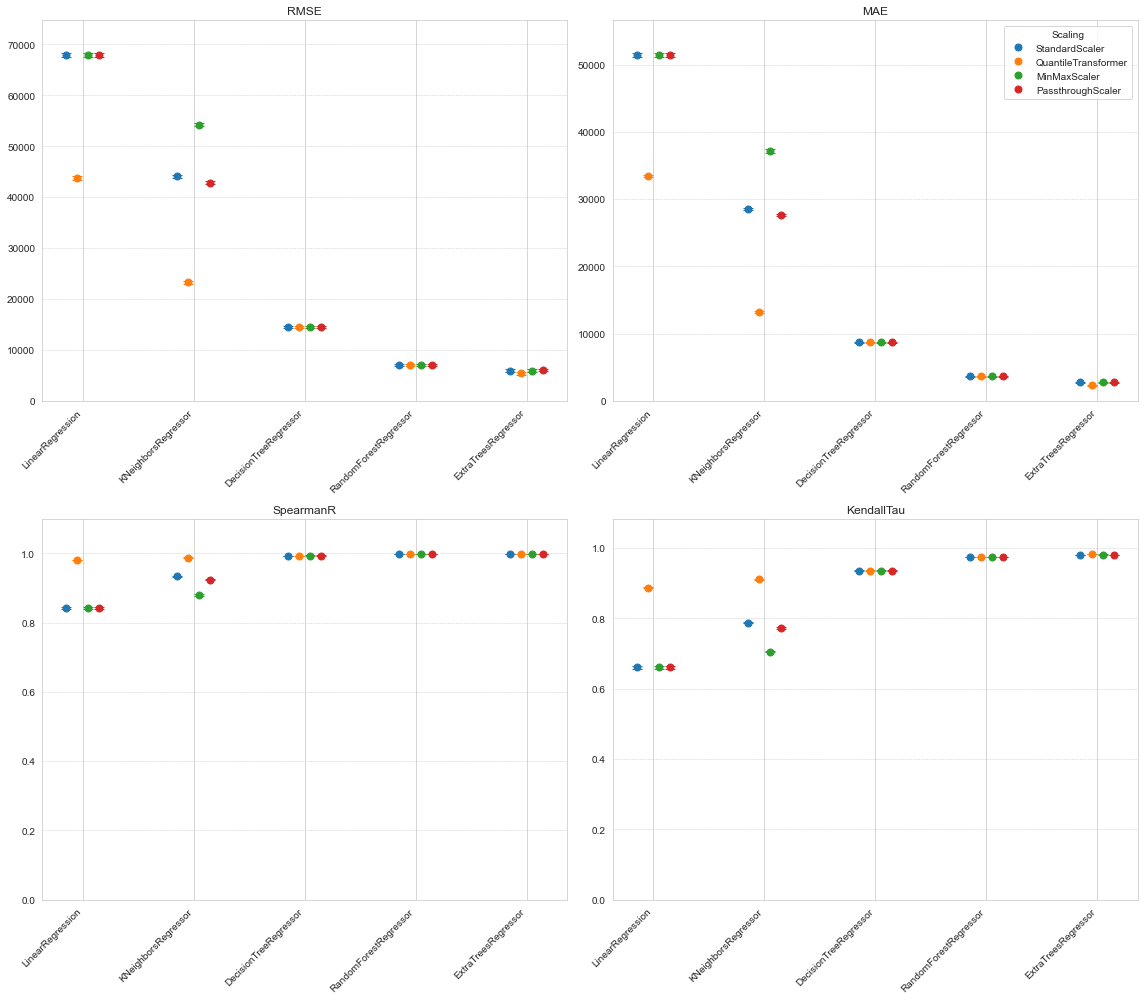

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_metric(ax, df, metric):
    metric_name = metric + " (mean)"
    std_name = metric + " (std)"
    
    # Extracting the colors used by seaborn for each hue level
    hue_order = df['Scaling'].unique()
    palette = sns.color_palette('tab10', n_colors=len(hue_order))
    color_dict = dict(zip(hue_order, palette))
    
    model_names = df['Model Name'].unique()
    model_name_to_idx = {name: idx for idx, name in enumerate(model_names)}
    
    # Offset calculation
    offset_multiplier = 0.1  # Adjust this value to increase/decrease the offset
    scaling_offsets = {scale: i * offset_multiplier for i, scale in enumerate(hue_order)}
    
    # Plotting using errorbar with matching colors
    for index, row in df.iterrows():
        x_position = model_name_to_idx[row['Model Name']] + scaling_offsets[row['Scaling']]
        ax.errorbar(x=x_position, y=row[metric_name], yerr=row[std_name], 
                    fmt='o', capsize=5, color=color_dict[row['Scaling']], markersize=7)

    # Setting up labels, title, and grid
    ax.set_title(metric_name.split()[0])
    #ax.set_ylabel(metric_name.split()[0])
    #ax.set_xlabel("Model Name")
    ax.set_xticks(np.arange(len(model_names)) + (len(hue_order) - 1) * offset_multiplier / 2)  # Centering ticks
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    max_y_value = df[metric_name].max()
    ax.set_ylim(bottom=0, top=max_y_value * 1.1)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    
    return color_dict, hue_order

# Create 2x2 subplots and call the plot_metric function for each metric
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

metrics = ['RMSE', 'MAE', 'SpearmanR', 'KendallTau']
for metric, ax in zip(metrics, axes.ravel()):
    color_dict, hue_order = plot_metric(ax, all_results, metric)

# Creating custom legend without error bars for the entire figure
legend_elements = [plt.Line2D([0], [0], color=color_dict[scale], marker='o', label=scale, markersize=7, linestyle="") for scale in hue_order]
fig.legend(handles=legend_elements, title='Scaling', loc='upper right', bbox_to_anchor=(0.99, 0.975))

plt.tight_layout()
plt.show()


## Some noteworthy findings from the results of the model evaluation:

- The linear regression model has the lowest performance.

- The Quantile Transformer generally leads to a better performance. This is likely caused by the distribution of the dataset and the many outliers and their distance from the average.

- The scaling method has a large impact on the performance of the KNeighbors model, which depends on a distance metric.

- The scaling plays a lower role for the tree based models.

- The best performance is achieved by the ExtraTrees model and the Quantile Transformer. The MAE of $2337 \pm 49$ is more than a an order of magnitude lower than a baseline of Linear Regression with Quantile Transformer $33455 \pm 190$.

Now that the different models are evaluated, we are going to visualize the results of the best performing model by comparing the predicted values to the real values.

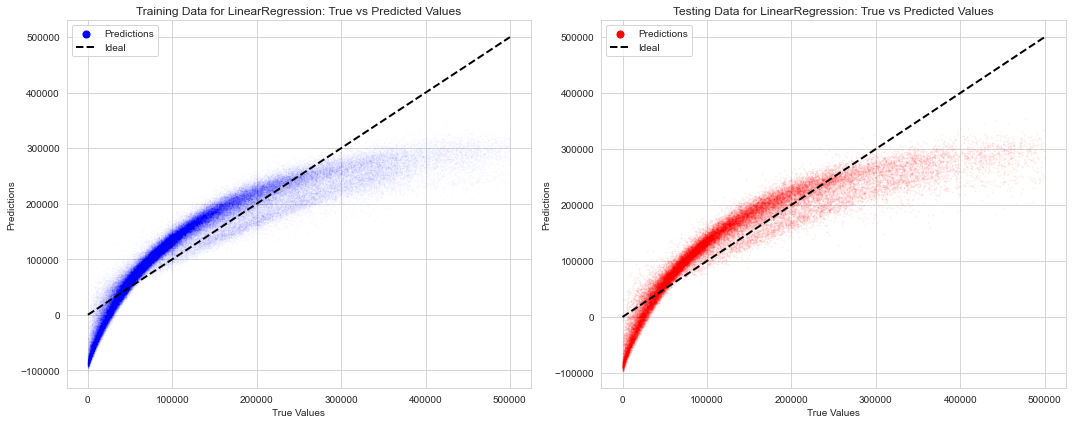

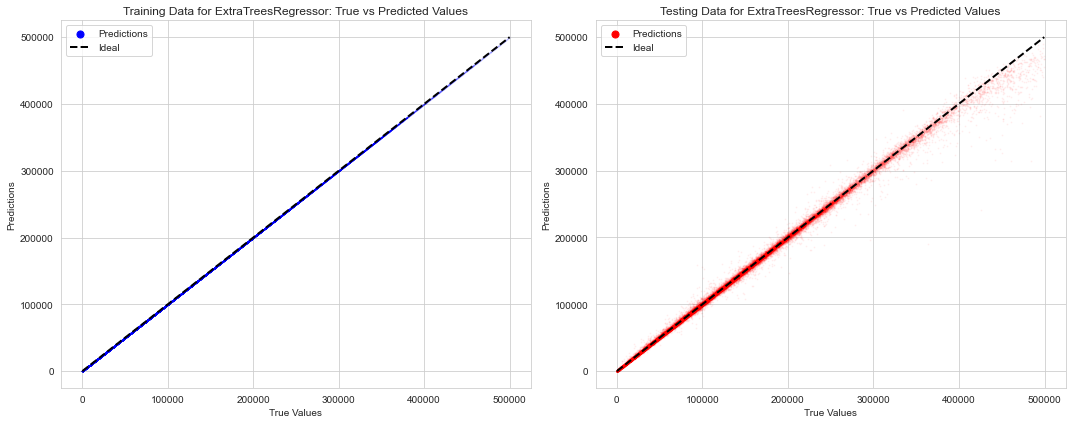

In [17]:
def visualize_predictions(model, X_train, y_train, X_test, y_test):
    # Fit model
    model.fit(X_train, y_train)
    model_name = type(model).__name__
    
    # Get predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Create plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training data scatterplot
    scatter_train = ax[0].scatter(y_train, train_preds, alpha=0.01, color='blue', s=1)  # smaller, more transparent
    line_train = ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2, label="Ideal")[0]
    # Create a "dummy" scatter plot for legend with bigger, opaque markers
    legend_train = ax[0].scatter([], [], alpha=1, color='blue', s=50, label="Predictions")  # bigger, full opacity
    ax[0].legend(handles=[legend_train, line_train], loc='upper left')
    ax[0].set_title(f"Training Data for {model_name}: True vs Predicted Values")
    ax[0].set_xlabel("True Values")
    ax[0].set_ylabel("Predictions")

    # Testing data scatterplot
    scatter_test = ax[1].scatter(y_test, test_preds, alpha=0.04, color='red', s=1)  # smaller, more transparent
    line_test = ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ideal")[0]
    # Create a "dummy" scatter plot for legend with bigger, opaque markers
    legend_test = ax[1].scatter([], [], alpha=1, color='red', s=50, label="Predictions")  # bigger, full opacity
    ax[1].legend(handles=[legend_test, line_test], loc='upper left')
    ax[1].set_title(f"Testing Data for {model_name}: True vs Predicted Values")
    ax[1].set_xlabel("True Values")
    ax[1].set_ylabel("Predictions")

    
    # Show plots
    plt.tight_layout()
    plt.show()

# Your provided code:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

random_state = 0
# Assuming df, predictors and target are defined elsewhere in your code
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size=0.2, random_state=random_state)

scaler = QuantileTransformer(random_state=random_state)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for model in [LinearRegression(), ExtraTreesRegressor(random_state=random_state)]:
    visualize_predictions(model, X_train_scaled, y_train, X_test_scaled, y_test)


### Findings from the predictions visualization

- The enhanced performance of the ExtraTrees model comared to the Linear Regression is clearly visible.

- The linear model is inadequate for describing the non-linear transformations used for generating the ranking.

- The ExtraTrees model shows a better performance on the training data compared to the testing data. This could be caused by overfitting and motivates further investigation.

## Improving the ranking

Now that we evaluated and visualized the performance of the machine learning models to predict the ranking, we are now going to try and use the best performing model to create tips for improving it. This should allow us to answer RQ2.

In the introduction, we defined the possible actions a scientist can do. Here are these actions along with their effect on the predictor metrics. We won't consider the impact on the h-index "h22 (ns)", the hm-index "hm22 (ns)", and the ratio of total citations to distinct citing papers "cprat (ns)", becuase we don't have enough information to determine how they would change. We also won't consider all possible combinations of getting a peer to cite a single/first/last authored cited/uncited paper. Instead we assume an uncited paper is single authored. If a peer agrees to cite the scientists paper, we assume it is in a new paper, so the number of distinct citing papers increases.

- publish a single authored paper
    - "np6022" += 1
    - "lastyr" = 2022
    - "nps (ns)" += 1
    - "cpsf (ns)" += 1
    - "npsfl (ns)" += 1
- publish a first authored paper
    - "np6022" += 1
    - "lastyr" = 2022
    - "cpsf (ns)" += 1
    - "npsfl (ns)" += 1
- publish a last authored paper
    - "np6022" += 1
    - "lastyr" = 2022
    - "npsfl (ns)" += 1
- get a peer to cite a single authored paper
    - "nc9622 (ns)" += 1
    - "ncs (ns)" += 1
    - "ncsf (ns)" += 1
    - "ncsfl (ns)" += 1
    - "npciting (ns)" += 1
    - "self%" change by 1
- get a peer to cite a first authored paper
    - "nc9622 (ns)" += 1
    - "ncsf (ns)" += 1
    - "ncsfl (ns)" += 1
    - "npciting (ns)" += 1
    - "self%" change by 1
- get a peer to cite a last authored paper
    - "nc9622 (ns)" += 1
    - "ncsfl (ns)" += 1
    - "npciting (ns)" += 1
    - "self%" change by 1
- get a peer to cite a previously uncited paper
    - "nc9622 (ns)" += 1
    - "ncs (ns)" += 1
    - "ncsf (ns)" += 1
    - "ncsfl (ns)" += 1
    - "npciting (ns)" += 1
    - "np6022 cited9622 (ns)" +=1
    - "self%" change by 1

## Generate and evaluate recommendations for improving the rank

In [18]:
# put the possible actions into operations on a dataframe
transformations_df = pd.DataFrame({
    "np6022": [1, 1, 1, 0, 0, 0, 0],
    "lastyr": [0, 0, 0, 0, 0, 0, 0],
    "nps (ns)": [1, 0, 0, 0, 0, 0, 0],
    "cpsf (ns)": [1, 1, 0, 0, 0, 0, 0],
    "npsfl (ns)": [1, 1, 1, 0, 0, 0, 0],
    "nc9622 (ns)": [0, 0, 0, 1, 1, 1, 1],
    "ncs (ns)": [0, 0, 0, 1, 0, 0, 1],
    "ncsf (ns)": [0, 0, 0, 1, 1, 0, 1],
    "ncsfl (ns)": [0, 0, 0, 1, 1, 1, 1],
    "npciting (ns)": [0, 0, 0, 1, 1, 1, 1],
    "np6022 cited9622 (ns)": [0, 0, 0, 0, 0, 0, 1],
    "self%": [0, 0, 0, 0, 0, 0, 0]
}, index=[
    "publish_single_auth",
    "publish_first_auth",
    "publish_last_auth",
    "get_cite_single_auth",
    "get_cite_first_auth",
    "get_cite_last_auth",
    "get_cite_uncited"
])

def update_self_perc(row, author_row):
    # check whether a citation was added in this row
    if transformations_df['npciting (ns)'].loc[row.name] == 1:
        # get current 'nc9622' (total number of citations including self-citations)
        nc9622 = author_row['nc9622'].values[0]
        # calculate the difference in 'self%' between current state and with new citation
        self_difference = row['nc9622 (ns)'] / nc9622 - (row['nc9622 (ns)'] + 1) / (nc9622 + 1)
        # return updated 'self%'
        return row["self%"] + self_difference
    else:
        # leave 'self%' unchanged
        return row["self%"]


def create_recommendations(author_row, transformations_df=transformations_df):
    # make sure author_row contains only one scientist
    assert len(author_row) == 1, "Pass df of length 1 as first argument 'author_row'"
    # create dataframe filled with the current values of the author
    author_unchanged = pd.concat([author_row[transformations_df.columns].T] * transformations_df.shape[0], axis=1).T.reset_index(drop=True)
    author_unchanged.index = transformations_df.index
    
    # apply the += 1 transformations
    recommendations = author_unchanged + transformations_df

    # update 'lastyr' to 2023 in case of a new publication (if 'npsfl (ns)' is += 1)
    recommendations['lastyr'] = recommendations.apply(lambda x: 2023 if transformations_df['npsfl (ns)'].loc[x.name] == 1 else x['lastyr'], axis=1)

    # update 'self%' in case of a citation by a peer
    recommendations['self%'] = recommendations.apply(update_self_perc, args=(author_row,), axis=1)
    
    # get remaining columns from orifinal dataframe
    columns_to_add = set(author_row.columns) - set(recommendations.columns)
    # add remaining columns unchanged
    for column_to_add in columns_to_add:
        recommendations[column_to_add] = author_row[column_to_add].values[0]
    
    return recommendations[author_row.columns]

## Evaluate the options using machine learning

In [19]:
def generate_prediction_ml(author_df, model=model, scaler=scaler, predictors=predictors):
    # get the prediction for the current values
    predictions = model.predict(scaler.transform(author_df[predictors]))
    return np.round(predictions).astype(int)
    
def evaluate_recommendations_ml(author_row, recommendations, model=model, scaler=scaler, predictors=predictors):
    # get the current prediction for the author
    current_prediction = generate_prediction_ml(author_row, model=model, scaler=scaler, predictors=predictors)
    # get the predictions of the authors recommendations
    recommendations_prediction = generate_prediction_ml(recommendations, model=model, scaler=scaler, predictors=predictors)

    # get the difference between the current prediction and the prediction of the options
    prediction_difference = pd.DataFrame(recommendations_prediction - current_prediction, index=recommendations.index, columns=['ml method'])

    return prediction_difference

## Evaluate the options using the formula

In [20]:
# define predictors: NC, H, Hm, NCS, NCSF, NCSFL
c_score_predictors = ["nc9622 (ns)", "h22 (ns)", "hm22 (ns)", "ncs (ns)", "ncsf (ns)", "ncsfl (ns)"]

# get c score maxlog from excel file for the denominator
c_score_maxlog_file = os.path.join('data', 'Table_3_maxlog_career_2022_pubs_since_1788_wopp_extracted_202310.xlsx')
c_score_maxlog_df = pd.read_excel(c_score_maxlog_file, sheet_name='Maxvalues')
c_score_maxlog = c_score_maxlog_df[c_score_predictors].iloc[0].to_dict()

# define target
c_score = "c (ns)"

def get_c_score(author_df, c_score_maxlog=c_score_maxlog, c_score=c_score):
    # create new dataframe for result
    c_scores = pd.DataFrame([],index=author_df.index)

    # define c-score function
    def calculate_row_c_score(row, c_score_maxlog):
        c_score = 0
        for predictor in c_score_maxlog.keys():
            # add log-transformed, scaled predictors to c_score
            c_score += np.log(row[predictor] + 1) / c_score_maxlog[predictor]
        return c_score

    c_scores['c_score_formula'] = author_df.apply(calculate_row_c_score, args=(c_score_maxlog,), axis=1)
    return c_scores

def evaluate_recommendations_formula(author_row, recommendations):
    # get the current calculated c-score for the author
    current_c_score_formula = get_c_score(author_row)
    # get the recommendation's calculated c-score
    recommendations_c_score_formula = get_c_score(recommendations)
    
    # get the difference between the recommendations' c-scores and the current c-score
    recommendations_c_score_formula['c-score_diff'] = recommendations_c_score_formula['c_score_formula'] - current_c_score_formula.values[0]
    return recommendations_c_score_formula[['c-score_diff']]

def get_rank_of_c_score(c_score, df=df):
    return df[df['c (ns)'] < c_score]['rank (ns)'].min()

def get_rank_difference_from_formula(author_row, recommendations):
    c_score_difference = evaluate_recommendations_formula(author_row, recommendations)
    c_score_difference['updated_c-score'] = c_score_difference['c-score_diff'] + author_row['c (ns)'].values[0]
    current_rank = get_rank_of_c_score(author_row['c (ns)'].values[0])
    c_score_difference['actual rank difference'] = c_score_difference['updated_c-score'].apply(get_rank_of_c_score) - current_rank
    return c_score_difference[['actual rank difference']]

In [21]:
# compare the impact of the recommendations using machine learning and the formula
def check_ml_evaluation_of_recommendations(author_index):
    author_row = df.iloc[[author_index]]
    recommendations = create_recommendations(author_row)
    evaluation_ml = evaluate_recommendations_ml(author_row, recommendations)
    evaluation_formula = get_rank_difference_from_formula(author_row, recommendations)
    return pd.concat([evaluation_ml, evaluation_formula], axis=1)

## Qualitative evaluation of the recommendation predictions

In order to evaluate the method of generating a recommendation from the machine learning model, we are going to share some examples to illustrate it's possibilities and limitations. 

**Disclaimers**: Note that this is not a quantitative evaluation, but rather based on manually checking examples and highlighting some observations. Also note that since we don't have precise information about the citations per publication, we can't determine the impact on the h-index and the hm-index. The "actual rank difference" from the formula will therefore show no change for the first three recommendations

- In general, the model often captures the trends, as seen the followig example (idx 105084). However, the exact amount is usually off. This is no surprise considering the MAE of this model is above 2000 and the actual changes in rank are often well below that.

In [22]:
check_ml_evaluation_of_recommendations(author_index = 105084)

,ml method,actual rank difference
publish_single_auth,-4,0
publish_first_auth,-37,0
publish_last_auth,0,0
get_cite_single_auth,-320,-228
get_cite_first_auth,-97,-34
get_cite_last_auth,-94,-20
get_cite_uncited,-320,-228


- In some cases (eg idx 116968, first 3 recommendations) the model predicts an increase in rank when publishing a paper, which goes against our expectation. This seems to show a limitation of our method.

In [23]:
check_ml_evaluation_of_recommendations(author_index = 116968)

,ml method,actual rank difference
publish_single_auth,526,0
publish_first_auth,271,0
publish_last_auth,271,0
get_cite_single_auth,-1014,-832
get_cite_first_auth,0,-31
get_cite_last_auth,0,-18
get_cite_uncited,-1014,-832


In some cases (eg idx 26483), even small differences can be detected remarkably well.

In [24]:
check_ml_evaluation_of_recommendations(author_index = 26483)

,ml method,actual rank difference
publish_single_auth,-13,0
publish_first_auth,-13,0
publish_last_auth,-13,0
get_cite_single_auth,-13,-17
get_cite_first_auth,-13,-12
get_cite_last_auth,-8,-4
get_cite_uncited,-13,-17


Aside from the performance of the model, we noticed that one recommendation often leads to a big improvement of the rank: getting a citation on a single authored paper, and therefore increasing "ncs (ns)".

An extreme example of this is idx 109199, which shows an improvement of 15722 ranks by adding one citation of a single authored paper.

In [25]:
check_ml_evaluation_of_recommendations(author_index = 109199)

,ml method,actual rank difference
publish_single_auth,-323,0
publish_first_auth,260,0
publish_last_auth,23,0
get_cite_single_auth,-14232,-15722
get_cite_first_auth,0,-18
get_cite_last_auth,0,-6
get_cite_uncited,-14232,-15722


Despite the models limitations, it shows some interesting and impressive results. This is a first test and the method has the potential to be built and improved upon.

In [26]:
check_ml_evaluation_of_recommendations(author_index = 166107)

,ml method,actual rank difference
publish_single_auth,0,0
publish_first_auth,0,0
publish_last_auth,0,0
get_cite_single_auth,-696,-777
get_cite_first_auth,-115,-101
get_cite_last_auth,0,-40
get_cite_uncited,-708,-777


## Conclusions

After running the experiments in the course of this project, we come to the following conclusions:

- **RQ1**: Can machine learning be used to predict a scientists rank above baseline? Answer: Yes, machine learning models are suitable for predicting the ranks of scientists using the input features of this dataset.

- The Quantile Transformer was shown to be the best scaling method. This is likely caused by the many outliers and their distance from the average data points.

- More complex models outperform linear models. This is likely caused by the non-linear operations, such as the log-transformations and the ranking.

- With a Mean Absolute Error (MAE) of $ 2336 \pm 49 $, the best performing model can predict the rank to some extent.

- The models we tested were all used with their default configurations. A hyperparameter tuning might improve performance.

- We generated different options for authors to improve their rankings. These options are either related to publishing papers or to getting peers to cite them.

- We were able to recreate the c-score using the formula. The ranking is based on this score.

- When calculating the impact of the options on the rank, we found that the differences are usually small compared to the MAE. Therefore, the model is not precise enough to predict such small differences.

- While the exact impact on the rank could usually not be determined, in many instances the model could identify the options which have lead to the biggest improvement.

- In some instances, the model predicts a negative impact for some of the options. This should not be the case, considering how the different metrics and the formula are defined.

- **RQ2**: Can these models be used to recommend steps to improve their ranking? Answer: The model can detect the impact of different actions on the ranking to some extent, but in the current version it cannot reliably generate recommendations and their exact impact on the ranking.

- When checking the options of different authors, a recurrent theme is the big impact of getting a citation on a single authored paper. This is likely caused by the numbers of citations on single authored papers being lower in general. A scientist who wants to improve their rank could be incentivised to publish single authored papers or to generate citations for them. Taken to an extreme, this could discourage collaboration. If this incentive should be removed from the ranking, a possible solution would be to add a factor to the maxlog of "ncs (ns)".


Outlook and possible improvements:

- Better models, either by using different algorithms or hyperparameter tuning could lead to an improvement.

- Including and adjusting the raw data for the h-index and hm-index would allow for a more precise evaluation of the impact of the recommendations.

- This could also be used to generate synthetic data by taking the current numbers of the scientists adding the changes of the recommendations and calculating the c-score using the formula.

- Currently the ml evaluation of the recommendations was only done in a qualitative way. In a follow up, this could be done quantitatively for all scientist. To keep the execution time low, this would require optimizing the code for such a task.

- A suitable metric for evaluating the recommendations would have to be chosen. This has to be done with a real world application in mind and has to reflect the value a scientist can get out of those recommendations. 